In [1]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from dataclasses import dataclass
import random
from enviroments import env_red_toy,env_red_toy1
import pickle
from algorithms.QL_LowRank import LRQL_algorithm
import time
from algorithms.models import QfunPARAFAC

NUMERO_DE_NUCLEOS = 16

torch.set_num_threads(NUMERO_DE_NUCLEOS)


In [2]:
name_exp = "Exp5"
Red_name = "red1"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "LR" #Puede ser LR/NN

In [3]:
T = 400

env = env_red_toy1(Demand_Model,T)

#Hiperarametros del algoritmo
gamma = 1
alpha = 1e-3
eps = 1.0
n = 4
eps_decay = 0.999997**(1/(n*(env.T/50)))
batch_size = 200

#Tamaño de la ejecución
max_episodes = 70000*n
max_steps = T

#Tamaño del bufer
buffer_size = 50_000

#Hiperparametros del modelo
exp_ranks = [8]


In [5]:
R_exp = []
time_exp = []
qfun_exp = []

for i, rank in enumerate(exp_ranks):

    print(f"Experimento {i}:")

    dims = [env.C[0]+1, env.C[1]+1, env.C[2] + 1,env.T+1, 2**(env.J)]
    qtensor = QfunPARAFAC(dims= dims, k = rank, scale= 0.1)
    
    opt = torch.optim.Adam(qtensor.parameters(), lr=alpha)

    start_time = time.time()
    qtensor, Rs, eps = LRQL_algorithm(max_episodes,max_steps, buffer_size,env, qtensor ,eps_decay,opt,gamma,batch_size,2**(env.J))
    end_time = time.time()
    execution_time = end_time - start_time

    R_exp.append(Rs)
    time_exp.append(execution_time)
    qfun_exp.append(qtensor)

Experimento 0:


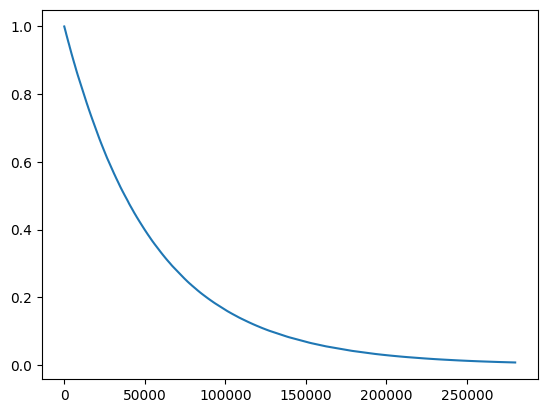

In [6]:
plt.plot(eps)

In [ ]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qfun_exp

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [4]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qfun_exp = exp["qfun_exp"] 


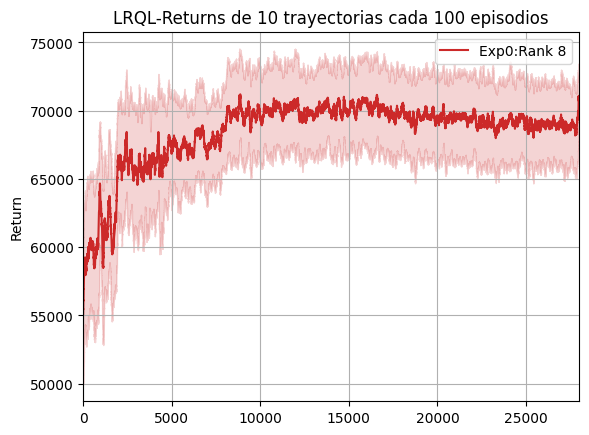

In [5]:
from algorithms.utils import generate_random_colors

num_plots = len(R_exp)  # Número de gráficas
colors = generate_random_colors(num_plots)

for i, R in enumerate(R_exp):

    Rs = np.array(R).ravel()

    mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[i],label= f"Exp{i}:Rank {exp_ranks[i]}")
    plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.2)

    plt.xlim(0, len(Rs))
    plt.grid()
    plt.ylabel("Return")
    plt.legend()
    plt.title("LRQL-Returns de 10 trayectorias cada 100 episodios")
    
plt.savefig("results/"+ name_exp +"/Returns_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

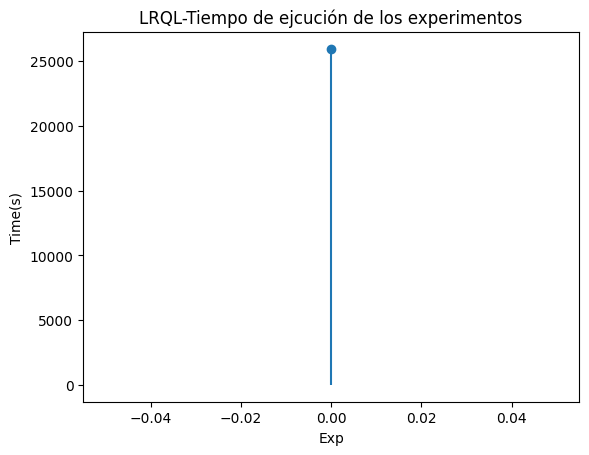

In [6]:
plt.title("LRQL-Tiempo de ejcución de los experimentos")
plt.stem(time_exp)
plt.xlabel("Exp")
plt.ylabel("Time(s)")

plt.savefig("results/"+ name_exp +"/Time_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

MovieWriter imagemagick unavailable; using Pillow instead.


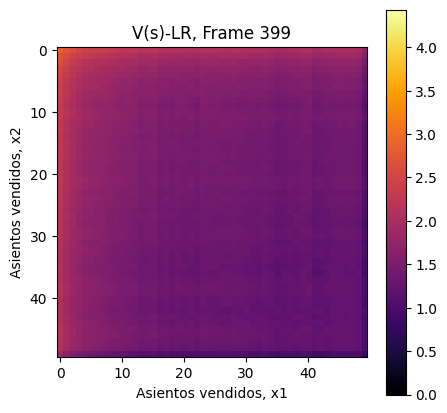

In [6]:
from algorithms.utils import saveGIFT
exp_to_plot = 4
saveGIFT(env, qfun_exp, "LR","log" ,[0,1],  "results/"+ name_exp +"/Qfun_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".gif")

In [10]:
from algorithms.utils import compare_Qfun_exp

name = "results/"+ name_exp +"/SelfQfunDiff_" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png"
diff_matrix = compare_Qfun_exp(env,qfun_exp,Qfun_model,name)

KeyboardInterrupt: 